In [1]:
import io
from PIL import Image
import numpy as np
import h5py
import matplotlib.pyplot as plt
from functools import reduce
import os

In [10]:
def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype("float32")
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map

def load_trial(hdf5_file_path, START_T, FINAL_T):
    flow_arr = []
    depth_arr = []
    image_arr = []
    seg_arr = []
    velocity_arr = []
    angular_velocity_arr = []
    with h5py.File(hdf5_file_path, "r") as f:
        distractors = (
            np.array(f["static"]["distractors"])
            if np.array(f["static"]["distractors"]).size != 0
            else []
        )
        occluders = (
            np.array(f["static"]["occluders"])
            if np.array(f["static"]["occluders"]).size != 0
            else []
        )
        distractors_occluders = np.concatenate([distractors, occluders])

        # extract depth info
        for frame in f["frames"].keys():
            if int(frame) >= FINAL_T or int(frame) < START_T:
                continue
            flow = np.array(f["frames"][frame]["images"]["_flow_cam0"])
            flow_arr.append(flow)
            depth = np.array(f["frames"][frame]["images"]["_depth_cam0"])
            depth_arr.append(depth)
            image = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_img_cam0"][:]))
            )
            image_arr.append(image)
            im_seg = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_id_cam0"][:]))
            )
            seg_arr.append(im_seg)

            velocities = np.array(f["frames"][frame]["objects"]["velocities"][:])
            angular_velocities = np.array(f["frames"][frame]["objects"]["angular_velocities"][:])
            if len(distractors_occluders):
                velocities = velocities[
                    : -len(distractors_occluders)
                ]
                angular_velocities = angular_velocities[
                    : -len(distractors_occluders)
                ]
            velocity_arr.append(velocities)
            angular_velocity_arr.append(angular_velocities)

        # flow_arr = np.asarray(flow_arr)
        depth_arr = np.asarray(depth_arr)
        image_arr = np.asarray(image_arr) / 255
        seg_arr = np.asarray(seg_arr)
        
        # extract object info
        object_ids = np.array(f["static"]["object_ids"])
        object_segmentation_colors = np.array(
            f["static"]["object_segmentation_colors"]
        )
        assert len(object_ids) == len(object_segmentation_colors)
        
        if len(distractors_occluders):
            object_ids = object_ids[: -len(distractors_occluders)]
            object_segmentation_colors = object_segmentation_colors[
                : -len(distractors_occluders)
            ]
    rgbds = np.concatenate(
        [image_arr, np.reshape(depth_arr, depth_arr.shape + (1,))], axis=-1
    )
    return (
        rgbds,
        flow_arr,
        seg_arr,
        sorted(object_ids),
        object_segmentation_colors,
        velocity_arr,
        angular_velocity_arr,
    )

def calculate_start_final(path):
    start = 0
    final = 45
    if "pilot_it2_collision" in path:
        final = 15
    if "dominoes" in path:
        start = 14
    return (start, final)

def cal_diff(rgbds, seg_arr, object_segmentation_colors, object_ids, velocity_arr, angular_velocity_arr):
    diffs = []
    vels = []
    angs = []
    for t in range(1, len(rgbds)):
        t1 = t-1
        seg1 = seg_arr[t1]
        seg2 = seg_arr[t]
        diff = rgbds[t][...,3] - rgbds[t1][...,3]
        for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
            mask1 = get_mask_area(seg1, [color])
            mask2 = get_mask_area(seg2, [color])
            mask = np.logical_and(mask1, mask2)
            area = diff[mask]
            diff_area = np.sum(area)
            diffs.append(np.abs(diff_area))
            vels.append(np.linalg.norm(velocity_arr[t][i]))
            angs.append(np.linalg.norm(angular_velocity_arr[t][i]))
    return diffs, vels, angs

In [15]:
diffs = []
vels = []
angs = []
path = '/home/haoliangwang/data/physion_hdf5/collide_all_movies'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            print(file)
            hdf5_file_path = os.path.join(root, file)
            start, final = calculate_start_final(hdf5_file_path)
            rgbds, flow_arr, seg_arr, object_ids, object_segmentation_colors, velocity_arr, angular_velocity_arr = load_trial(hdf5_file_path, start, final)
            diff, vel, ang = cal_diff(rgbds, seg_arr, object_segmentation_colors, object_ids, velocity_arr, angular_velocity_arr)
            diffs.extend(diff)
            vels.extend(vel)
            angs.extend(ang)

pilot_it2_collision_simple_box_1_dis_1_occ_0034.hdf5
pilot_it2_collision_non-sphere_box_0003.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0038.hdf5
pilot_it2_collision_tiny_ball_box_0023.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0025.hdf5
pilot_it2_collision_simple_box_1_dis_1_occ_0014.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0025.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0039.hdf5
pilot_it2_collision_tiny_ball_box_0037.hdf5
pilot_it2_collision_simple_box_1_dis_1_occ_0018.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0028.hdf5
pilot_it2_collision_tiny_ball_box_0013.hdf5
pilot_it2_collision_non-sphere_box_0012.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0021.hdf5
pilot_it2_collision_assorted_targets_box_0017.hdf5
pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0030.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0039.hdf5
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0007.hdf5
pilot_it2_collision_simple_box_0017.hdf5
pilot_it2_collision_non-sphere_box_0021.hdf5

KeyboardInterrupt: 

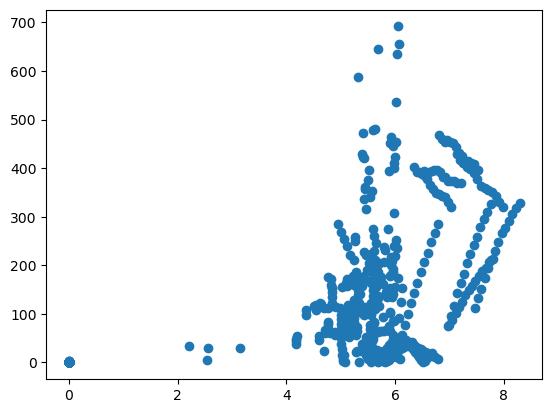

In [16]:
plt.scatter(vels, diffs)

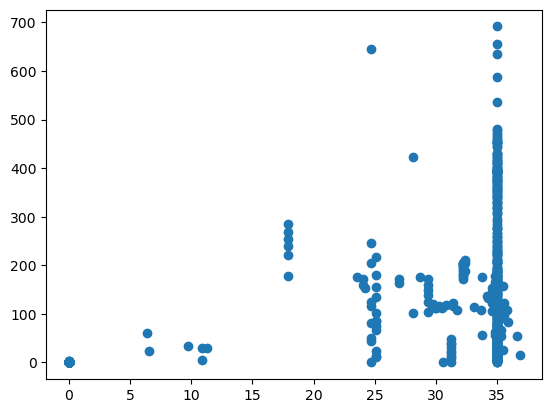

In [17]:
plt.scatter(angs, diffs)

In [32]:
zero_vel_indices = [i for i, x in enumerate(vels) if x == 0]
corr_diffs = [diffs[idx] for idx in zero_vel_indices]
if any(elt != 0 for elt in corr_diffs):
    print("Non zero detected")
else:
    print("All elements are zero")

All elements are zero


In [39]:
zero_diff_indices = [i for i, x in enumerate(diffs) if x == 0]
corr_vels = [vels[idx] for idx in zero_diff_indices]
if any(np.abs(elt) > 1e-05 for elt in corr_vels):
    print("Non zero detected")
else:
    print("All elements are zero")

All elements are zero


In [40]:
diffs

[0.0,
 0.0,
 105.30630278587341,
 0.0,
 0.003725767135620117,
 107.1027946472168,
 0.0,
 0.0,
 114.41938614845276,
 0.0,
 0.0,
 108.94799876213074,
 0.0,
 0.0,
 115.44370746612549,
 0.0,
 0.002335071563720703,
 121.83983445167542,
 0.0,
 0.002335071563720703,
 118.01499509811401,
 0.0,
 0.002335071563720703,
 111.68697166442871,
 0.0,
 0.002335071563720703,
 114.74663758277893,
 0.0,
 0.002335071563720703,
 115.27725577354431,
 0.0,
 0.0,
 112.93396091461182,
 0.0,
 0.002335071563720703,
 111.73572111129761,
 0.0,
 0.0,
 120.04216313362122,
 0.0,
 0.0,
 116.22936654090881,
 0.0,
 0.005461454391479492,
 56.185425996780396,
 0.0,
 0.0016720294952392578,
 21.013108253479004,
 0.0,
 0.0,
 23.31079125404358,
 0.0,
 0.004704952239990234,
 110.5832793712616,
 0.0,
 0.004704952239990234,
 588.0346493721008,
 0.0,
 0.0,
 115.75651502609253,
 0.0,
 0.004704952239990234,
 645.8251252174377,
 0.0,
 0.004704952239990234,
 246.90920162200928,
 0.0,
 0.0,
 124.09623122215271,
 0.0,
 0.004704952239990

In [44]:
hdf5_file_path = "/home/haoliangwang/data/physion_hdf5/contain_all_movies/pilot-containment-cone-plate_0031.hdf5"
# hdf5_file_path = "/home/haoliangwang/data/physion_hdf5/collide_all_movies/pilot_it2_collision_assorted_targets_box_0003.hdf5"
rgbds, flow_arr, seg_arr, object_ids, object_segmentation_colors, velocity_arr, angular_velocity_arr = load_trial(hdf5_file_path, 0, 45)

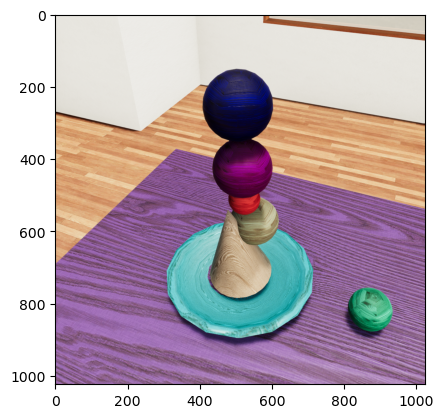

In [45]:
plt.imshow(rgbds[0][...,:3])

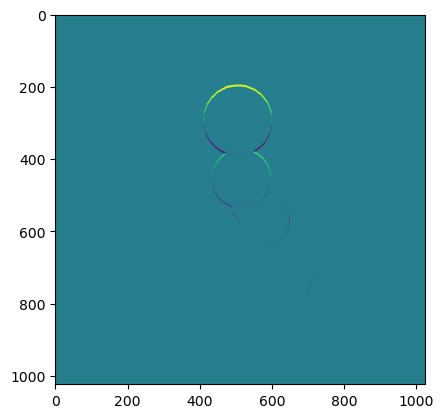

In [8]:
t1 = 12
t2 = 13

# plt.imshow(rgbds[t2][...,:3] - rgbds[t1][...,:3])
# plt.imshow(rgbds[t2] - rgbds[t1])
plt.imshow(rgbds[t2][...,3] - rgbds[t1][...,3])

In [14]:
for t in range(1, 45):
    print(t)
    t1 = t-1
    seg1 = seg_arr[t1]
    seg2 = seg_arr[t]
    # diff = rgbds[t] - rgbds[t1]
    diff = rgbds[t][...,3] - rgbds[t1][...,3]
    # diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
    for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
        mask1 = get_mask_area(seg1, [color])
        area1 = diff[mask1]
        diff_area1 = np.sum(area1)
        
        mask2 = get_mask_area(seg2, [color])
        area2 = diff[mask2]
        diff_area2 = np.sum(area2)
        # print(f"Object {o_id}: {np.abs(diff_area1)}, {np.abs(diff_area2)}")
        print(f"Object {o_id}: {np.abs(diff_area1)+np.abs(diff_area2)}")
        # if np.abs(diff_area2) > 100.0:
        #     print(f"Object {o_id}: {diff_area2 + diff_area1}")

        # fig = plt.figure(figsize=[10, 5])
        # ax = fig.add_subplot(121)
        # ax.imshow(area1)
        # ax = fig.add_subplot(122)
        # ax.imshow(area2)
        # fig.suptitle(f'{diff_area2 + diff_area1}')



1
Object 1: 0.0
Object 2: 0.006872653961181641
Object 3: 830.3834629058838
2
Object 1: 0.0
Object 2: 0.0007624626159667969
Object 3: 775.3617413043976
3
Object 1: 0.0
Object 2: 0.0011792182922363281
Object 3: 797.7116115093231
4
Object 1: 0.0
Object 2: 0.0009050369262695312
Object 3: 827.5373408794403
5
Object 1: 0.0
Object 2: 0.0009050369262695312
Object 3: 841.9913663864136
6
Object 1: 0.0
Object 2: 0.0
Object 3: 861.685338973999
7
Object 1: 0.0
Object 2: 0.0
Object 3: 886.3532838821411
8
Object 1: 0.0
Object 2: 0.0
Object 3: 888.5845777988434
9
Object 1: 0.0
Object 2: 0.0002741813659667969
Object 3: 896.7177956104279
10
Object 1: 0.0
Object 2: 0.0
Object 3: 900.9870340824127
11
Object 1: 0.0
Object 2: 0.0002741813659667969
Object 3: 887.9562435150146
12
Object 1: 0.0
Object 2: 0.0
Object 3: 879.8965404033661
13
Object 1: 0.0
Object 2: 0.0006546974182128906
Object 3: 834.8782210350037
14
Object 1: 0.0
Object 2: 0.0006546974182128906
Object 3: 847.7418985366821


In [46]:
for t in range(1, 45):
    print(t)
    t1 = t-1
    seg1 = seg_arr[t1]
    seg2 = seg_arr[t]
    # diff = rgbds[t] - rgbds[t1]
    diff = rgbds[t][...,3] - rgbds[t1][...,3]
    # diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
    for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
        mask1 = get_mask_area(seg1, [color])
        mask2 = get_mask_area(seg2, [color])
        mask = np.logical_and(mask1, mask2)
        area = diff[mask]
        diff_area = np.sum(area)
        
        print(f"Object {o_id}: {np.abs(diff_area)}")
        # if np.abs(diff_area2) > 100.0:
        #     print(f"Object {o_id}: {diff_area2 + diff_area1}")

        # fig = plt.figure(figsize=[10, 5])
        # ax = fig.add_subplot(121)
        # ax.imshow(area1)
        # ax = fig.add_subplot(122)
        # ax.imshow(area2)
        # fig.suptitle(f'{diff_area2 + diff_area1}')



1
Object 1: 0.0
Object 3: 57.802138566970825
Object 4: 926.7136869430542
Object 5: 9.732092142105103
Object 6: 31.79235339164734
Object 7: 7.394039630889893
Object 8: 1.7786720991134644
Object 9: 28.887104868888855
2
Object 1: 0.0
Object 3: 30.874035835266113
Object 4: 215.78261041641235
Object 5: 17.89255714416504
Object 6: 8.576469421386719
Object 7: 0.46726489067077637
Object 8: 6.132762670516968
Object 9: 42.80840075016022
3
Object 1: 0.0
Object 3: 17.891533374786377
Object 4: 54.29503560066223
Object 5: 22.710775136947632
Object 6: 21.2614164352417
Object 7: 0.22399473190307617
Object 8: 21.556625366210938
Object 9: 56.64206397533417
4
Object 1: 0.0
Object 3: 8.579693078994751
Object 4: 19.442094087600708
Object 5: 17.237265586853027
Object 6: 22.959337949752808
Object 7: 1.5240399837493896
Object 8: 29.07247745990753
Object 9: 71.73834991455078
5
Object 1: 0.0
Object 3: 1.2337002754211426
Object 4: 11.415213584899902
Object 5: 23.56268000602722
Object 6: 26.31609010696411
Object 

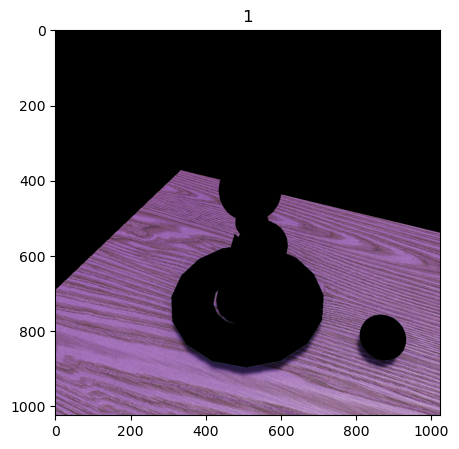

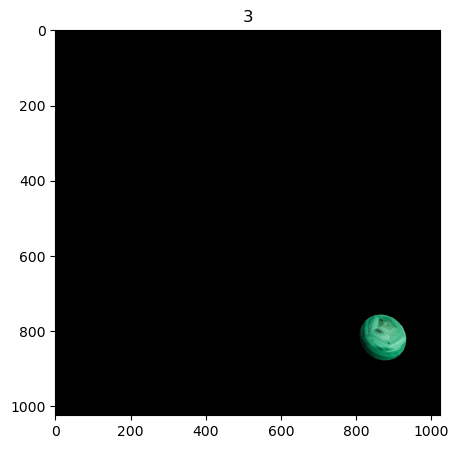

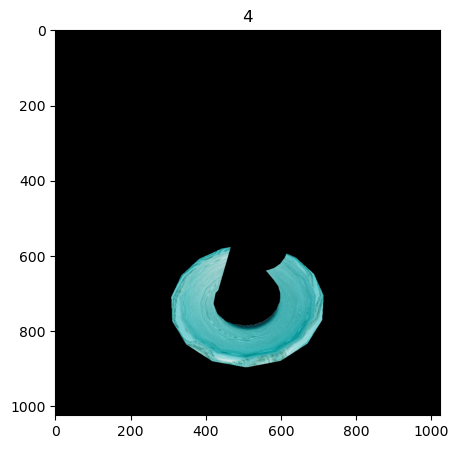

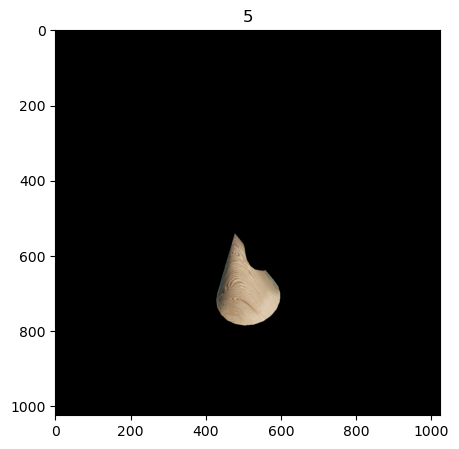

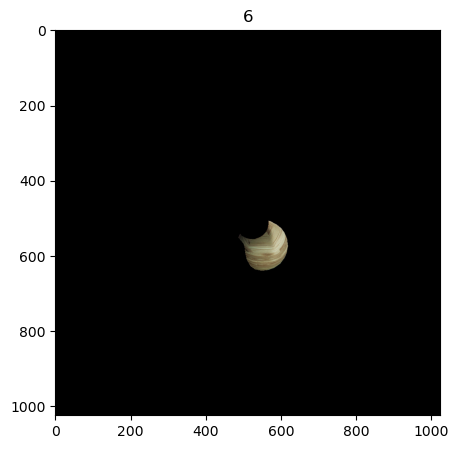

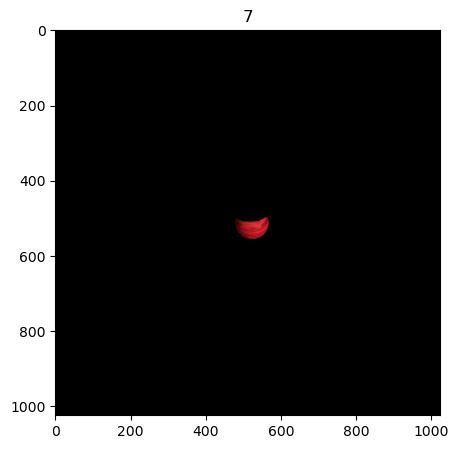

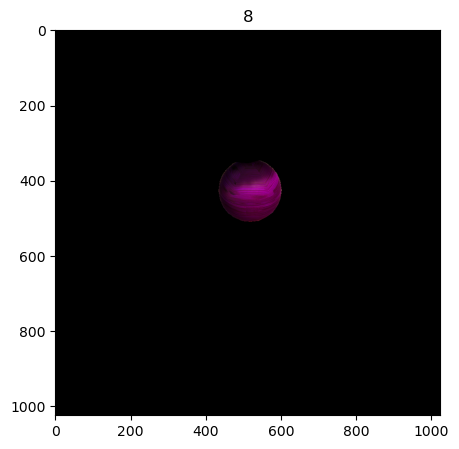

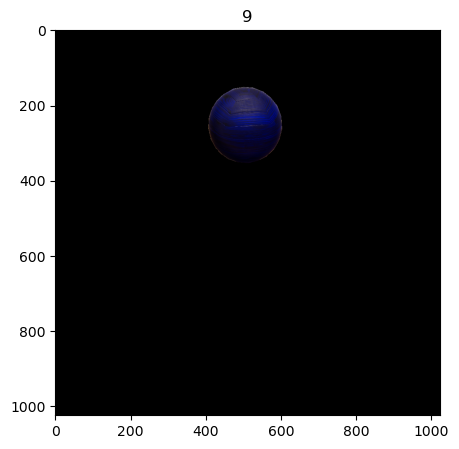

In [11]:
# loop over all seg masks
for o_id, color in zip(object_ids, object_segmentation_colors):
    area = get_mask_area(seg_arr[0], [color])
    image_masked = blackout_image(rgbds[0][...,:3], area)
    rgb_masked = image_masked[..., 0:3]

    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    ax.imshow(rgb_masked)
    ax.set_title(f"{o_id}")

In [27]:
rgbds[1][...,:3]-rgbds[0][...,:3]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        ...,
        [-0.00392157, -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ]],

       [[ 0.00392157,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157]],

       [[ 0.00392157,  0.00392157,  0.        ],
        [ 0.        , -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        , -0.00392157],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16078431372549018..0.18039215686274512].


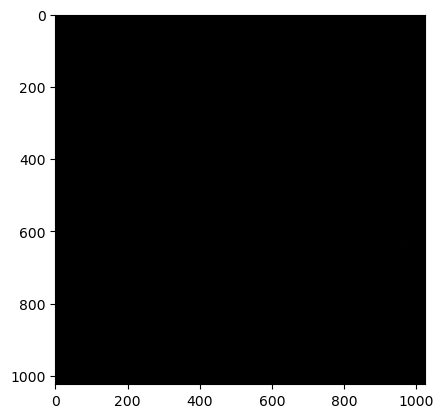

In [22]:
plt.imshow(rgbds[1][...,:3]-rgbds[0][...,:3])

In [12]:
(rgbds[t2] - rgbds[t1]).shape

(1024, 1024, 4)

In [13]:
rgbds[t2] - rgbds[t1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.        ,  0.00392157,  0.        ],
        [ 0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.00392157,  0.        ],
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        , -0.00392157,  0.        ],
        [-0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [-0.00392157,  0.  

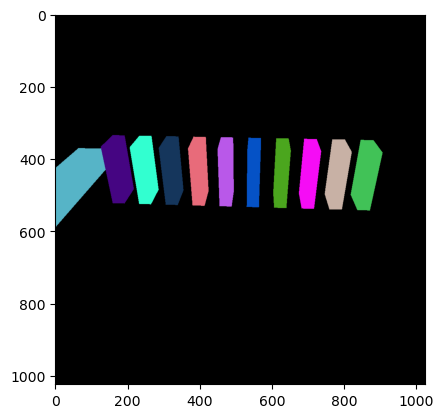

In [14]:
plt.imshow(seg_arr[0])

In [2]:
import os
import h5py
import numpy as np

In [4]:
path = '/home/haoliangwang/data/physion_hdf5/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            with h5py.File(os.path.join(root, file), "r") as f:
                fwait = np.array(f["static"]["push_time"])
                # push_force = np.array(f["static"]["push_force"])
            print(fwait, file)

1 pilot-containment-cone-plate_0031.hdf5
1 pilot-containment-bowl-familiarization_0018.hdf5
1 pilot-containment-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0048.hdf5
1 pilot-containment-cylinder-bowl_0021.hdf5
5 pilot-containment-vase_torus_0033.hdf5
1 pilot-containment-multi-bowl_0029.hdf5
1 pilot-containment-bowl-familiarization_0033.hdf5
5 pilot-containment-vase_torus_0009.hdf5
1 pilot-containment-multi-bowl_0025.hdf5
5 pilot-containment-vase_torus_0043.hdf5
5 pilot-containment-vase_torus_0031.hdf5
1 pilot-containment-bowl-familiarization_0026.hdf5
5 pilot-containment-vase_torus_0032.hdf5
1 pilot-containment-torus_0022.hdf5
1 pilot-containment-bowl-familiarization_0024.hdf5
1 pilot-containment-bowl-familiarization_0035.hdf5
1 pilot-containment-bowl_0000.hdf5
1 pilot-containment-cylinder-bowl_0010.hdf5
5 pilot-containment-vase_0000.hdf5
1 pilot-containment-cylinder-bowl_0028.hdf5
1 pilot-containment-cylinder-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0042.hdf5
1 pilot-containmen